In [1]:
import numpy as np 
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os 
import torch 
import random 
import pickle
from auto  import AutoEncoder
from funcs import *
from torch import nn
from sklearn.model_selection  import KFold
from torchvision.datasets import MNIST
from torchvision.transforms import Compose,ToTensor
from torch.utils.data import DataLoader, Subset 

In [3]:
#!mkdir ./mnsitdata

In [4]:
data_dir = './mnsitdata/'

In [5]:
train_transform = Compose([ToTensor(),])
test_transform = Compose([ToTensor(),])

In [6]:
train_data = MNIST(data_dir, train=True, download=True, transform=train_transform)
test_data = MNIST(data_dir, train=False, download=True, transform=test_transform)

In [7]:
#img = test_data[6][0].unsqueeze(0).to(device)

#plt.imshow(np.squeeze(img))

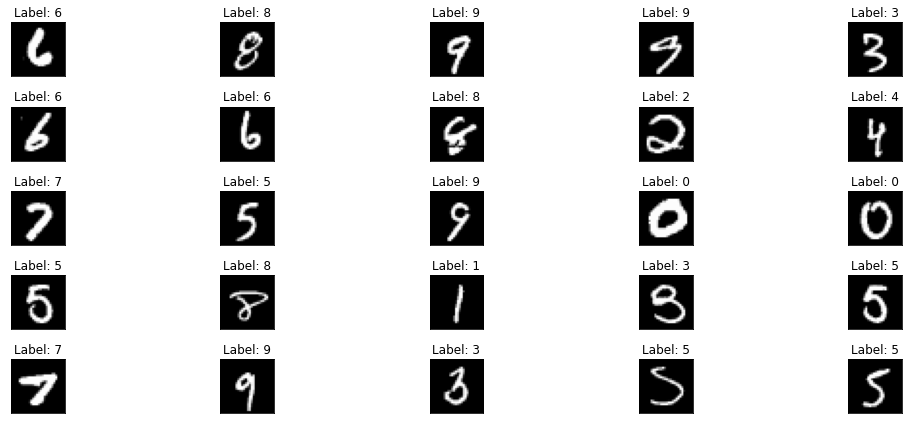

In [8]:
plt.close('all')
fig, axs = plt.subplots(5,5,figsize=(16,6))
for ax in axs.flatten():
    img, label = random.choice(train_data)
    ax.imshow(img.squeeze().numpy(), cmap='gist_gray')
    ax.set_title('Label: %d' %label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


In [10]:
batch_size = 1000
epochs = 20 
encoded_space_dim = 4
net = AutoEncoder(encoded_space_dim).to(device)

In [11]:
img = test_data[0][0].unsqueeze(0)
print('Original image shape: ', img.shape)
enc_img = net.encode(img)
print('Encoded img shape: ', enc_img.shape)
dec_img = net.decode(enc_img)
print('Decoded img shape: ',dec_img.shape)
del img, enc_img, dec_img

Original image shape:  torch.Size([1, 1, 28, 28])
Encoded img shape:  torch.Size([1, 4])
Decoded img shape:  torch.Size([1, 1, 28, 28])


### load data

In [12]:
train_dl = DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_dl = DataLoader(test_data,batch_size=batch_size,shuffle=False)
loss_fn = torch.nn.MSELoss()

In [13]:
#!mkdir ./results
#!mkdir ./results/losses

### Gridsearch 

In [ ]:
idxs = list(range(len(train_data)))
for lr in [1e-2,1e-3,1e-4]:
    for weight_decay in [1e-3, 1e-4, 1e-5]:
        res = train_cross_val(idxs, device,train_data,encoded_dim=encoded_space_dim,
                                 lr=lr,wd=weight_decay,epochs=epochs)
        with open(f'./results/losses/cross_val_loss{encoded_space_dim}_{lr}_{weight_decay}.pickle','wb') as f:
            pickle.dump(res,f)

Fold: 0
|Epoch> 1/20
	Training loss: 0.092758
	Validation loss: 0.068708
|Epoch> 2/20
	Training loss: 0.068264
	Validation loss: 0.067778
|Epoch> 3/20
	Training loss: 0.067755
	Validation loss: 0.067117
|Epoch> 4/20
	Training loss: 0.066322
	Validation loss: 0.064769
|Epoch> 5/20
	Training loss: 0.064444
	Validation loss: 0.064021
|Epoch> 6/20
	Training loss: 0.064202
	Validation loss: 0.063879
|Epoch> 7/20
	Training loss: 0.064090
	Validation loss: 0.063904
|Epoch> 8/20
	Training loss: 0.064102
	Validation loss: 0.063927
|Epoch> 9/20
	Training loss: 0.064052
	Validation loss: 0.063742
|Epoch> 10/20
	Training loss: 0.064008
	Validation loss: 0.063769
|Epoch> 11/20
	Training loss: 0.063997
	Validation loss: 0.063763
|Epoch> 12/20
	Training loss: 0.063996
	Validation loss: 0.063771
|Epoch> 13/20
	Training loss: 0.063967
	Validation loss: 0.063777
|Epoch> 14/20
	Training loss: 0.063988
	Validation loss: 0.063787
|Epoch> 15/20
	Training loss: 0.064022
	Validation loss: 0.063723
|Epoch> 16/

In [ ]:
#!mkdir images

#### Results

In [ ]:
def cv_plots(): 
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c','#9467bd',
              '#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']
    
    spaceD = 4
    train_traces = {}
    val_traces = {}
    i = 0
    for lr in [1e-2, 1e-3, 1e-4]: # learning rate cycle
        for decay in [1e-3, 1e-4, 1e-5]: # weight decay cycle
            # retrive data
            with open(f'results/losses/cross_val_loss{spaceD}_{lr}_{decay}.pickle','rb') as f:
                results = pickle.load(f)
            train_traces['trace_' + str(lr+i)]=go.Scatter(x=list(range(len(results['train_loss']))),
                                 y=results['train_loss'] ,
                                 name=fr'$\eta:{lr}\enspace \omega D:{decay}$',
                                mode='lines+markers', marker=dict(size=3),
                                line=dict(color=colors[i], width=1.5, dash='solid'))
            val_traces['trace_' + str(lr+i)]=go.Scatter(x=list(range(len(results['val_loss']))),
                                 y=results['val_loss'] ,
                                name=fr'$\eta:{lr}\enspace\omega D:{decay}$',showlegend = False,
                                mode='lines+markers', marker=dict(size=3),
                                line=dict(color=colors[i], width=1.5, dash='dash'))
            i += 1
    data=list(train_traces.values()) + list(val_traces.values())
    fig=go.Figure(data)
    fig.update_layout(legend=dict(yanchor="top",y=0.84,xanchor="center",x=0.8,
                     title = ''),xaxis_title='Epochs', yaxis_title='Loss',
                     height=700, width=975,plot_bgcolor='#dbd4d0',
                    title_text=f'Cross validation ecoded_space_dim={spaceD}',title_x=0.5, title_y=0.9)
    fig.show()

In [ ]:
cv_plots()

#### Analysis using best params : lr = 1e-2, wD = 1e-5

In [ ]:
ecoded_space_dim = 4
net = AutoEncoder(encoded_space_dim=encoded_space_dim)
epochs = 100
lr = 1e-2
weight_decay = 1e-5
optim = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
train_log_loss= []
val_loss_log = []

In [ ]:
 %matplotlib inline

In [ ]:
#### show the first ten and and the 

In [ ]:
for epoch  in range(epochs):
    
    train_loss = trainfunc(net, dataloader=train_dl, loss_fn=loss_fn,optimizer=optim,device=device)
    val_loss = testfunc(net, dataloader=test_dl, loss_fn=loss_fn,optimizer=optim,device=device)
    if epoch<=4 or 24<=epoch<=29 or 64<=epoch<=69 or epoch >=94:
        print(f'\n|Epoch>: {epoch + 1}/{epochs}')
        print('\n\tTraining loss: %f'% (train_loss))
        print('\tValidation loss: %f'% (val_loss))
    # show progress 
    img = test_data[6][0].unsqueeze(0).to(device)
    net.eval()
    with torch.no_grad():
        rec_img = net(img) # reconstructed image
    if epoch <= 10 or epoch >= 90:
        fig, axs = plt.subplots(1, 2, figsize=(12,6))
        axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        axs[0].set_title('Original Image')
        axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
        axs[1].set_title('Reconstructed Image (Epoch %d)' % (epoch + 1))
        plt.pause(0.1)
        plt.tight_layout()
        os.makedirs('./images/progress_%d_features' % encoded_space_dim, exist_ok=True)
        plt.savefig('./images/progress_%d_features/epoch_%d.png' % (encoded_space_dim, epoch + 1))
        plt.close()
        plt.show()

    # Save network parameters
    torch.save(net.state_dict(), f'./results/net_params_{encoded_space_dim}.pth')
    train_log_loss.append(train_loss)
    val_loss_log.append(val_loss)

    # Early stopping
    if epoch>100 and abs(val_loss_log[-1] - val_loss_log[-100]) < 0.001:
        break            

In [ ]:
def losses_plots(trace, data, colors, spaceD, h, w):
    
    """ data: list of lists
        spaceD:
            ecoding space dimension
        colors:
            list containing colors 
    """
    traces = {}
    traces['trace_' + str(trace[0])]=go.Scatter(x=list(range(len(data[0]))),
                             y=data[0], name='Training',
                             mode='lines+markers', marker=dict(size=3),
                             line=dict(color=colors[0], width=1.5, dash='solid'))
    traces['trace_' + str(trace[1])]=go.Scatter(x=list(range(len(data[1]))),
                         y=data[1] ,name='Validation',
                         mode='lines+markers', marker=dict(size=3),
                         line=dict(color=colors[1], width=1.5, dash='solid'))
    data=list(traces.values())
    fig=go.Figure(data)                       
    fig.update_layout(legend=dict(yanchor="top",y=0.84,xanchor="center",x=0.8,
                                  title = ''),xaxis_title='Epochs', yaxis_title='Loss',
                    height=h, width=w,plot_bgcolor='#dbd4d0',
                 title_text=f'Losses ecoded_space_dim={spaceD}',
                  title_x=0.5, title_y=0.9)
    fig.show()

In [ ]:
losses_plots([0,1],[train_log_loss,val_loss_log], ['green','red'],4,700,900)

### Tests 

In [ ]:
encoded_spaceD = 4

# select device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#load network
params = torch.load(f'./results/net_params_{encoded_spaceD}.pth', map_location = device)
net = AutoEncoder(encoded_space_dim = encoded_spaceD)
net.load_state_dict(params)
net.to(device)
loss_fn = torch.nn.MSELoss()
 
# definedataloader
train_dl = DataLoader(train_data, batch_size=1000, shuffle=True)
test_dl = DataLoader(test_data, batch_size=1000, shuffle=False)

#### Standard Images

In [ ]:
net.eval() # evaluation mode (e.g. disable dropout)
with torch.no_grad(): # no need to track the gradients
    conc_out = torch.Tensor().float()
    conc_label = torch.Tensor().float()
    for batch in test_dl:
        imgbatch = batch[0].to(device)
        out = net(imgbatch) # Forward pass
        # concatenate with previous outputs
        conc_out = torch.cat([conc_out, out.cpu()])
        conc_label = torch.cat([conc_label, imgbatch.cpu()]) 

    # plot images
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original", fontsize=18)
    plt.imshow(imgbatch[4].squeeze().cpu(), cmap='gist_gray')
    plt.subplot(1, 3, 2)
    plt.title("Reconstructed", fontsize=18)
    plt.imshow(out[4].squeeze().cpu(), cmap='gist_gray')
    plt.savefig("images/Original.png")
    plt.show()
    # evaluate global loss
    test_loss = loss_fn(conc_out, conc_label)
    print(f'Test loss: {test_loss.numpy()}')

#### Randomly Corrupted Images


In [ ]:
sigmaL  = [0.01, 0.1, 0.3, 1, 4]

# gaussian noise

gauss_err=[]
for s in sigmaL:
    err = test_rand_noise(net=net, dataloader=test_dl,loss_fn=loss_fn,
                                    device=device, noise ='Gaussian',
                                    sigma=s) 
    gauss_err.append(err)


# occlusion noise
occlusion_err = test_rand_noise(net=net,dataloader=test_dl, 
                                    loss_fn=loss_fn,device=device,
                                    noise='Occlusion') 


# uniform error
uniform_err = test_rand_noise(net=net, dataloader=test_dl,loss_fn=loss_fn,
                                    device=device, noise ='Uniform')

print("\nGnoise:\t\t\terror")
for i,s in enumerate(sigmaL):
    add_tab=''
    if s in [1,4]: add_tab = '\t'
    print(f"\tN(0,{s})","\t",add_tab,gauss_err[i].numpy())
print("occlusion\t\t",occlusion_err.numpy())
print("uniform\t\t",uniform_err.numpy())


## Latent Space Analysis

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
encoded_spaceD = 4
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
params = torch.load(f'./results/net_params_{encoded_spaceD}.pth', map_location = device)

In [ ]:
net = AutoEncoder(encoded_space_dim = encoded_spaceD)
net.load_state_dict(params)
net.to(device)


encoded_test_samples = []
for sample in tqdm(test_data):
    img = sample[0].unsqueeze(0)
    label = sample[1]
    net.eval()
    with torch.no_grad():
        encoded_img  = net.encode(img)
    encoded_test_samples.append((encoded_img.flatten().numpy(), label))

#### PCA 

In [ ]:
encoded_array = np.array(encoded_test_samples)
encoding = encoded_array[:,0]
label = encoded_array[:,1]
#set(list(labels))
for i, enc in enumerate(encoding): 
    encoding[i] = enc.reshape((encoded_space_dim)) # reshape data
standard_data = StandardScaler().fit_transform(list(encoding)) # standardise data
pca = PCA(n_components=3)
components = pca.fit_transform(standard_data)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(components, x=0, y=1, z=2, opacity=0.8,#animation_frame=label,
                    color=label,width=950,height=800,animation_group=label,
    labels={'0': 'PC1', '1': 'PC2', '2': 'PC3'},
                    #log_x=True,# log_y=True,log_z=True
)
fig.update_layout(legend=dict(yanchor="top",y=0.84,xanchor="center",
                              x=0.94,title = 'label'),
                 title_text=f'Total Explained Variance: {total_var:.2f}%',
                  title_x=0.5, title_y=0.9)
fig.show(renderer='')